In [1]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.linear_model import RidgeCV,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import scipy.stats as stats

In [ ]:
from fig_5_helper import shuffle_along_axis_coherent, shuffle_phase_coherent, shuffle_magnitude_coherent
from fig_5_helper import compute_r2, compute_statistics
from fig_5_helper import catname, bout_cols

Shuffling the Phase of a Signal

        The phase of a signal carries information about the timing of the signal's oscillations. By shuffling the phase, you disrupt the temporal order of the signal while keeping the amplitude spectrum (or power) intact.

Shuffling the Power of a Signal

        Power is related to the amplitude of the signal's frequency components. By shuffling the power, you keep the phase information but randomize the amplitude distribution across frequencies.


In [5]:
bout_cat =np.arange(0,11,1)

In [6]:
fig_dir = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_5\fig_5')
fig_dir.mkdir(exist_ok=True, parents=True)

## Load data

In [7]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\fin_tail_nn')
ds = np.load(Path(master_path /'fin_data'/'model_data_test.npz'))
print(*ds.files,sep="\n")

original_index
proba
clusters
tail_dir
tails
fins
reconstructions
latents
inputs
model_targets
original_tensor


In [8]:
ds = np.load(Path(master_path /'fin_data'/'model_data_test.npz'))
ds['reconstructions'].shape, ds['tails'].shape, ds['model_targets'].shape, ds['inputs'].shape,  ds['fins'].shape, ds['latents'].shape


((1823, 7, 175),
 (1824, 7, 175),
 (1823, 7, 175),
 (1823, 10, 175),
 (1824, 2, 175),
 (1823, 120, 175))

In [9]:
# pull out bout features
swim_cat = ds['clusters'] # bout type
swim_direction = ds['tail_dir'] # direction
proba = ds['proba'] # direction
# pull out bout tensors
fins = ds['fins'][:-1,:,:]
tails = ds['tails'][:-1,:,:]
latents = ds['latents']
inputs = ds['inputs']
recons = ds['reconstructions']

# dims
n_trials, n_segs, n_tps = recons.shape
_, n_fins, _ = fins.shape
_, n_latents, _ = latents.shape
_, n_inputs, _ = inputs.shape

print(f"n trials: {n_trials}, n tps: {n_tps}, n fins: {n_fins}, n latents: {n_latents}")

tt_ = np.arange(n_tps)*10/7

n trials: 1823, n tps: 175, n fins: 2, n latents: 120


### Shuffle fins

    1. FFT Fins

    Types of shuffle:
    2. Shuffle Phase, keep power
    3. Shuffle Power, Keep Phase

    4. Run 1000 times shuffle and compute R2
    5. Compare significance level
    6. Do the same for tail
    

In [10]:
fft_fins = np.fft.fft(fins, axis=-1)

In [11]:
# Apply coherent shuffling
shuffled_phase_fins = np.zeros_like(fft_fins, dtype=np.complex128)

for trial in range(fft_fins.shape[0]):
    shuffled_phase_fins[trial] = shuffle_phase_coherent(fft_fins[trial])

# Reconstruct the time series from the shuffled phase FFT data
shuffled_time_series_phase = np.zeros_like(fft_fins, dtype=np.float64)

for trial in range(shuffled_phase_fins.shape[0]):
    for fin in range(shuffled_phase_fins.shape[1]):
        # Use inverse FFT to get back to time domain
        shuffled_time_series_phase[trial, fin] = np.fft.ifft(shuffled_phase_fins[trial, fin]).real


In [12]:
# Apply coherent magnitude shuffling
shuffled_magnitude_fins = np.zeros_like(fft_fins, dtype=np.complex128)

for trial in range(fft_fins.shape[0]):
    shuffled_magnitude_fins[trial] = shuffle_magnitude_coherent(fft_fins[trial])

# Reconstruct the time series from the shuffled magnitude FFT data
shuffled_time_series_power = np.zeros_like(fft_fins, dtype=np.float64)

for trial in range(shuffled_magnitude_fins.shape[0]):
    for fin in range(shuffled_magnitude_fins.shape[1]):
        # Use inverse FFT to get back to time domain
        shuffled_time_series_power[trial, fin] = np.fft.ifft(shuffled_magnitude_fins[trial, fin]).real


In [13]:
shuffled_time_series_phase.shape, shuffled_time_series_power.shape

((1823, 2, 175), (1823, 2, 175))

### Compute R2

In [14]:
r_vals = compute_r2(latents, fins)
print (latents.shape, fins.shape)

Mean Squared Error: 0.04113910714418859
(1823, 120, 175) (1823, 2, 175)


In [15]:
r_vals_phase = compute_r2(latents, shuffled_time_series_phase)
print (latents.shape, shuffled_phase_fins.shape)

Mean Squared Error: 0.06047881555101761
(1823, 120, 175) (1823, 2, 175)


In [16]:
r_vals_power = compute_r2(latents, shuffled_time_series_power)
print (latents.shape, shuffled_time_series_power.shape)

Mean Squared Error: 0.0512397636750073
(1823, 120, 175) (1823, 2, 175)


### now lets run it x times

In [18]:
num_iterations = 100
r2_phase_results = []
r2_power_results = []

for _ in tqdm(range(num_iterations)):
    shuffled_phase_fins = np.zeros_like(fft_fins)
    for trial in range(fft_fins.shape[0]):
        shuffled_phase_fins[trial] = shuffle_phase_coherent(fft_fins[trial])

    # Reconstruct the time series from the shuffled phase FFT data
    shuffled_time_series_phase = np.zeros_like(fft_fins, dtype=np.float64)  # Use np.float64 for the real part
    
    for trial in range(shuffled_phase_fins.shape[0]):
        for fin in range(shuffled_phase_fins.shape[1]):
            # Use inverse FFT to get back to time domain
            shuffled_time_series_phase[trial, fin] = np.fft.ifft(shuffled_phase_fins[trial, fin]).real
            
    r2_phase = compute_r2(latents, shuffled_time_series_phase)
    r2_phase_results.append(r2_phase)
    
    # # Shuffle power and compute R²
    shuffled_power_fins = np.zeros_like(fft_fins)
    for trial in range(fft_fins.shape[0]):
        shuffled_power_fins[trial] = shuffle_magnitude_coherent(fft_fins[trial])

    # Reconstruct the time series from the shuffled magnitude FFT data
    shuffled_time_series_power = np.zeros_like(fft_fins, dtype=np.float64)  # Use np.float64 for the real part
    
    for trial in range(shuffled_power_fins.shape[0]):
        for fin in range(shuffled_power_fins.shape[1]):
            # Use inverse FFT to get back to time domain
            shuffled_time_series_power[trial, fin] = np.fft.ifft(shuffled_power_fins[trial, fin]).real
        
    r2_power = compute_r2(latents, shuffled_time_series_power)
    r2_power_results.append(r2_power)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Mean Squared Error: 0.06319400098617883
Mean Squared Error: 0.05130075314598347
Mean Squared Error: 0.04113910714418858


  1%|▊                                                                                 | 1/100 [00:18<30:46, 18.66s/it]

Mean Squared Error: 0.06374226449972033
Mean Squared Error: 0.05125092400955789
Mean Squared Error: 0.041139107144188565


  2%|█▋                                                                                | 2/100 [00:37<31:07, 19.06s/it]

Mean Squared Error: 0.0610078792427322
Mean Squared Error: 0.05155969678573589
Mean Squared Error: 0.04113910714418853


  3%|██▍                                                                               | 3/100 [00:56<30:22, 18.79s/it]

Mean Squared Error: 0.06174374939145821
Mean Squared Error: 0.051052103886664764
Mean Squared Error: 0.04113910714418857


  4%|███▎                                                                              | 4/100 [01:15<30:19, 18.95s/it]

Mean Squared Error: 0.06219506368770276
Mean Squared Error: 0.05131502458402546
Mean Squared Error: 0.04113910714418857


  5%|████                                                                              | 5/100 [01:33<29:29, 18.63s/it]

Mean Squared Error: 0.06253340554420747
Mean Squared Error: 0.050801949470795714
Mean Squared Error: 0.041139107144188586


  6%|████▉                                                                             | 6/100 [01:56<31:09, 19.89s/it]

Mean Squared Error: 0.06037252009135915
Mean Squared Error: 0.05128492623918961
Mean Squared Error: 0.04113910714418862


  7%|█████▋                                                                            | 7/100 [02:16<30:53, 19.93s/it]

Mean Squared Error: 0.06521813962841741
Mean Squared Error: 0.0506553897217693
Mean Squared Error: 0.041139107144188586


  8%|██████▌                                                                           | 8/100 [02:35<30:20, 19.79s/it]

Mean Squared Error: 0.0669773668441519
Mean Squared Error: 0.051333654137029706
Mean Squared Error: 0.04113910714418853


  9%|███████▍                                                                          | 9/100 [02:54<29:39, 19.55s/it]

Mean Squared Error: 0.06480765860557805
Mean Squared Error: 0.051405766021420315
Mean Squared Error: 0.04113910714418858


 10%|████████                                                                         | 10/100 [03:12<28:24, 18.93s/it]

Mean Squared Error: 0.06334043572091282
Mean Squared Error: 0.050822026161110714
Mean Squared Error: 0.04113910714418856


 11%|████████▉                                                                        | 11/100 [03:31<28:06, 18.95s/it]

Mean Squared Error: 0.06040922813779828
Mean Squared Error: 0.05102793297375228
Mean Squared Error: 0.04113910714418858


 12%|█████████▋                                                                       | 12/100 [03:49<27:31, 18.77s/it]

Mean Squared Error: 0.06521798954379159
Mean Squared Error: 0.05101671400828271
Mean Squared Error: 0.04113910714418858


 13%|██████████▌                                                                      | 13/100 [04:09<27:36, 19.04s/it]

Mean Squared Error: 0.062832216630914
Mean Squared Error: 0.05169708586968487
Mean Squared Error: 0.041139107144188614


 14%|███████████▎                                                                     | 14/100 [04:28<27:22, 19.09s/it]

Mean Squared Error: 0.06467470040901284
Mean Squared Error: 0.05095501176418383
Mean Squared Error: 0.041139107144188614


 15%|████████████▏                                                                    | 15/100 [04:47<26:52, 18.97s/it]

Mean Squared Error: 0.062379408745232935
Mean Squared Error: 0.05082827231522042
Mean Squared Error: 0.041139107144188544


 16%|████████████▉                                                                    | 16/100 [05:06<26:42, 19.07s/it]

Mean Squared Error: 0.06332790743906223
Mean Squared Error: 0.051338455251252545
Mean Squared Error: 0.04113910714418852


 17%|█████████████▊                                                                   | 17/100 [05:24<26:05, 18.87s/it]

Mean Squared Error: 0.06306145316902574
Mean Squared Error: 0.051091106257418556
Mean Squared Error: 0.04113910714418856


 18%|██████████████▌                                                                  | 18/100 [05:49<28:04, 20.55s/it]

Mean Squared Error: 0.06247911184400978
Mean Squared Error: 0.05154730247210756
Mean Squared Error: 0.04113910714418857


 19%|███████████████▍                                                                 | 19/100 [06:18<31:05, 23.03s/it]

Mean Squared Error: 0.06300802931259694
Mean Squared Error: 0.0516334741512157
Mean Squared Error: 0.0411391071441885


 20%|████████████████▏                                                                | 20/100 [06:36<29:00, 21.75s/it]

Mean Squared Error: 0.06338354843200272
Mean Squared Error: 0.051192129930998156
Mean Squared Error: 0.04113910714418858


 21%|█████████████████                                                                | 21/100 [06:56<27:53, 21.19s/it]

Mean Squared Error: 0.06374326687096728
Mean Squared Error: 0.051105573984628214
Mean Squared Error: 0.04113910714418856


 22%|█████████████████▊                                                               | 22/100 [07:15<26:38, 20.49s/it]

Mean Squared Error: 0.06181280597090852
Mean Squared Error: 0.051730460833918517
Mean Squared Error: 0.04113910714418858


 23%|██████████████████▋                                                              | 23/100 [07:34<25:39, 19.99s/it]

Mean Squared Error: 0.06333719838498915
Mean Squared Error: 0.05134547554741428
Mean Squared Error: 0.04113910714418855


 24%|███████████████████▍                                                             | 24/100 [07:55<25:53, 20.44s/it]

Mean Squared Error: 0.06189532376750028
Mean Squared Error: 0.05124146746543947
Mean Squared Error: 0.041139107144188614


 25%|████████████████████▎                                                            | 25/100 [08:16<25:39, 20.52s/it]

Mean Squared Error: 0.0642913321279303
Mean Squared Error: 0.05111016834492936
Mean Squared Error: 0.04113910714418854


 26%|█████████████████████                                                            | 26/100 [08:35<24:51, 20.15s/it]

Mean Squared Error: 0.06474165605013703
Mean Squared Error: 0.051372673453759336
Mean Squared Error: 0.04113910714418861


 27%|█████████████████████▊                                                           | 27/100 [08:54<23:56, 19.67s/it]

Mean Squared Error: 0.06398960322176903
Mean Squared Error: 0.05152979242202165
Mean Squared Error: 0.0411391071441886


 28%|██████████████████████▋                                                          | 28/100 [09:12<23:06, 19.26s/it]

Mean Squared Error: 0.06455998309136332
Mean Squared Error: 0.051002014788010815
Mean Squared Error: 0.04113910714418858


 29%|███████████████████████▍                                                         | 29/100 [09:32<23:02, 19.48s/it]

Mean Squared Error: 0.06271586269876762
Mean Squared Error: 0.05159444152385309
Mean Squared Error: 0.04113910714418856


 30%|████████████████████████▎                                                        | 30/100 [09:53<23:03, 19.76s/it]

Mean Squared Error: 0.06435479028754668
Mean Squared Error: 0.05088501970179736
Mean Squared Error: 0.041139107144188586


 31%|█████████████████████████                                                        | 31/100 [10:12<22:38, 19.69s/it]

Mean Squared Error: 0.06171092894880191
Mean Squared Error: 0.050485422238058277
Mean Squared Error: 0.0411391071441886


 32%|█████████████████████████▉                                                       | 32/100 [10:30<21:35, 19.05s/it]

Mean Squared Error: 0.06320541539443453
Mean Squared Error: 0.051675757151641556
Mean Squared Error: 0.04113910714418853


 33%|██████████████████████████▋                                                      | 33/100 [10:49<21:18, 19.09s/it]

Mean Squared Error: 0.06288741574351611
Mean Squared Error: 0.05208876234499996
Mean Squared Error: 0.04113910714418855


 34%|███████████████████████████▌                                                     | 34/100 [11:08<21:04, 19.15s/it]

Mean Squared Error: 0.0647907825060218
Mean Squared Error: 0.05168625541077089
Mean Squared Error: 0.04113910714418859


 35%|████████████████████████████▎                                                    | 35/100 [11:28<20:57, 19.34s/it]

Mean Squared Error: 0.0637837956085993
Mean Squared Error: 0.05102949261397159
Mean Squared Error: 0.04113910714418858


 36%|█████████████████████████████▏                                                   | 36/100 [11:47<20:23, 19.12s/it]

Mean Squared Error: 0.06339860661688679
Mean Squared Error: 0.05133363776502549
Mean Squared Error: 0.04113910714418858


 37%|█████████████████████████████▉                                                   | 37/100 [12:07<20:20, 19.38s/it]

Mean Squared Error: 0.06402320041435708
Mean Squared Error: 0.051051185628606055
Mean Squared Error: 0.04113910714418857


 38%|██████████████████████████████▊                                                  | 38/100 [12:31<21:36, 20.92s/it]

Mean Squared Error: 0.062355838748529124
Mean Squared Error: 0.05131663334335273
Mean Squared Error: 0.04113910714418852


 39%|███████████████████████████████▌                                                 | 39/100 [12:51<20:57, 20.62s/it]

Mean Squared Error: 0.06229895335309009
Mean Squared Error: 0.05131897260877001
Mean Squared Error: 0.041139107144188565


 40%|████████████████████████████████▍                                                | 40/100 [13:10<20:01, 20.03s/it]

Mean Squared Error: 0.06468576819547776
Mean Squared Error: 0.0511420918774188
Mean Squared Error: 0.041139107144188544


 41%|█████████████████████████████████▏                                               | 41/100 [13:29<19:23, 19.72s/it]

Mean Squared Error: 0.062367136788565924
Mean Squared Error: 0.051273980971284855
Mean Squared Error: 0.04113910714418862


 42%|██████████████████████████████████                                               | 42/100 [13:47<18:40, 19.31s/it]

Mean Squared Error: 0.06482954938440277
Mean Squared Error: 0.050949495610550295
Mean Squared Error: 0.04113910714418853


 43%|██████████████████████████████████▊                                              | 43/100 [14:05<18:03, 19.02s/it]

Mean Squared Error: 0.06400044954739804
Mean Squared Error: 0.050857772801312706
Mean Squared Error: 0.04113910714418856


 44%|███████████████████████████████████▋                                             | 44/100 [14:24<17:32, 18.79s/it]

Mean Squared Error: 0.06258653795316818
Mean Squared Error: 0.0514205888261452
Mean Squared Error: 0.04113910714418864


 45%|████████████████████████████████████▍                                            | 45/100 [14:45<17:53, 19.52s/it]

Mean Squared Error: 0.06524163102642631
Mean Squared Error: 0.05116589789122435
Mean Squared Error: 0.04113910714418854


 46%|█████████████████████████████████████▎                                           | 46/100 [15:05<17:47, 19.77s/it]

Mean Squared Error: 0.06301844484723387
Mean Squared Error: 0.051714661340684025
Mean Squared Error: 0.04113910714418856


 47%|██████████████████████████████████████                                           | 47/100 [15:29<18:28, 20.91s/it]

Mean Squared Error: 0.061614507289982676
Mean Squared Error: 0.051567914074144613
Mean Squared Error: 0.04113910714418862


 48%|██████████████████████████████████████▉                                          | 48/100 [15:54<19:17, 22.25s/it]

Mean Squared Error: 0.0612017160871484
Mean Squared Error: 0.051379790399811096
Mean Squared Error: 0.04113910714418859


 49%|███████████████████████████████████████▋                                         | 49/100 [16:20<19:57, 23.47s/it]

Mean Squared Error: 0.06326401894793016
Mean Squared Error: 0.051440294561385276
Mean Squared Error: 0.04113910714418855


 50%|████████████████████████████████████████▌                                        | 50/100 [16:39<18:25, 22.11s/it]

Mean Squared Error: 0.06272847672888307
Mean Squared Error: 0.05048937757420851
Mean Squared Error: 0.0411391071441886


 51%|█████████████████████████████████████████▎                                       | 51/100 [16:58<17:18, 21.19s/it]

Mean Squared Error: 0.06200915533057829
Mean Squared Error: 0.05081867286862111
Mean Squared Error: 0.041139107144188586


 52%|██████████████████████████████████████████                                       | 52/100 [17:19<16:47, 20.99s/it]

Mean Squared Error: 0.06132476934410915
Mean Squared Error: 0.05096295719275289
Mean Squared Error: 0.04113910714418856


 53%|██████████████████████████████████████████▉                                      | 53/100 [17:38<15:53, 20.29s/it]

Mean Squared Error: 0.0629945769811454
Mean Squared Error: 0.051763208537980054
Mean Squared Error: 0.04113910714418858


 54%|███████████████████████████████████████████▋                                     | 54/100 [17:58<15:31, 20.25s/it]

Mean Squared Error: 0.06328863547824998
Mean Squared Error: 0.051690671339417855
Mean Squared Error: 0.041139107144188565


 55%|████████████████████████████████████████████▌                                    | 55/100 [18:18<15:16, 20.37s/it]

Mean Squared Error: 0.06216345358039376
Mean Squared Error: 0.05110077331200333
Mean Squared Error: 0.041139107144188544


 56%|█████████████████████████████████████████████▎                                   | 56/100 [18:40<15:07, 20.63s/it]

Mean Squared Error: 0.06221028206274795
Mean Squared Error: 0.05098862739133253
Mean Squared Error: 0.041139107144188544


 57%|██████████████████████████████████████████████▏                                  | 57/100 [19:00<14:49, 20.69s/it]

Mean Squared Error: 0.06267720272905343
Mean Squared Error: 0.051052204401862165
Mean Squared Error: 0.041139107144188544


 58%|██████████████████████████████████████████████▉                                  | 58/100 [19:22<14:35, 20.85s/it]

Mean Squared Error: 0.06260010794399097
Mean Squared Error: 0.05094328558114526
Mean Squared Error: 0.041139107144188565


 59%|███████████████████████████████████████████████▊                                 | 59/100 [19:43<14:18, 20.93s/it]

Mean Squared Error: 0.06172864230539961
Mean Squared Error: 0.05115239918570123
Mean Squared Error: 0.04113910714418858


 60%|████████████████████████████████████████████████▌                                | 60/100 [20:00<13:16, 19.92s/it]

Mean Squared Error: 0.0615893978424774
Mean Squared Error: 0.051628632514159514
Mean Squared Error: 0.04113910714418859


 61%|█████████████████████████████████████████████████▍                               | 61/100 [20:17<12:23, 19.07s/it]

Mean Squared Error: 0.0644468334130134
Mean Squared Error: 0.05153274610156517
Mean Squared Error: 0.04113910714418858


 62%|██████████████████████████████████████████████████▏                              | 62/100 [20:36<11:55, 18.84s/it]

Mean Squared Error: 0.061700538868290196
Mean Squared Error: 0.05166129159606006
Mean Squared Error: 0.04113910714418858


 63%|███████████████████████████████████████████████████                              | 63/100 [20:52<11:09, 18.10s/it]

Mean Squared Error: 0.060134339847745175
Mean Squared Error: 0.05131945437808068
Mean Squared Error: 0.04113910714418854


 64%|███████████████████████████████████████████████████▊                             | 64/100 [21:08<10:30, 17.53s/it]

Mean Squared Error: 0.06354839868017186
Mean Squared Error: 0.05116711956217123
Mean Squared Error: 0.04113910714418859


 65%|████████████████████████████████████████████████████▋                            | 65/100 [21:24<09:58, 17.10s/it]

Mean Squared Error: 0.06237097091173603
Mean Squared Error: 0.051806487773565
Mean Squared Error: 0.0411391071441886


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [21:41<09:32, 16.85s/it]

Mean Squared Error: 0.0628202795151695
Mean Squared Error: 0.05081786965498791
Mean Squared Error: 0.04113910714418856


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [21:57<09:09, 16.65s/it]

Mean Squared Error: 0.06322419972772217
Mean Squared Error: 0.05138462112635595
Mean Squared Error: 0.04113910714418861


 68%|███████████████████████████████████████████████████████                          | 68/100 [22:13<08:47, 16.48s/it]

Mean Squared Error: 0.06080364064454379
Mean Squared Error: 0.05132060537767111
Mean Squared Error: 0.041139107144188565


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [22:29<08:27, 16.36s/it]

Mean Squared Error: 0.06241567613651585
Mean Squared Error: 0.051243639473225855
Mean Squared Error: 0.04113910714418861


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [22:45<08:08, 16.30s/it]

Mean Squared Error: 0.06446788987233482
Mean Squared Error: 0.05096019376432738
Mean Squared Error: 0.04113910714418858


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [23:01<07:51, 16.27s/it]

Mean Squared Error: 0.06211784040385562
Mean Squared Error: 0.05072405267723487
Mean Squared Error: 0.041139107144188565


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [23:18<07:36, 16.29s/it]

Mean Squared Error: 0.0626703264856739
Mean Squared Error: 0.05113718947776712
Mean Squared Error: 0.04113910714418852


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [23:34<07:18, 16.24s/it]

Mean Squared Error: 0.060218095498798536
Mean Squared Error: 0.05130139509034958
Mean Squared Error: 0.0411391071441886


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [23:50<07:02, 16.23s/it]

Mean Squared Error: 0.06108463188582294
Mean Squared Error: 0.050990274862393874
Mean Squared Error: 0.04113910714418857


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [24:06<06:44, 16.20s/it]

Mean Squared Error: 0.061722626181435314
Mean Squared Error: 0.051072699655469116
Mean Squared Error: 0.04113910714418855


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [24:22<06:28, 16.20s/it]

Mean Squared Error: 0.06240886604305906
Mean Squared Error: 0.05142025029047262
Mean Squared Error: 0.04113910714418858


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [24:39<06:13, 16.23s/it]

Mean Squared Error: 0.06529554749660427
Mean Squared Error: 0.05108051608735697
Mean Squared Error: 0.04113910714418863


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [24:55<05:56, 16.20s/it]

Mean Squared Error: 0.060518227327252754
Mean Squared Error: 0.05103872832513574
Mean Squared Error: 0.041139107144188634


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [25:11<05:39, 16.18s/it]

Mean Squared Error: 0.060491502935905724
Mean Squared Error: 0.05157363749891114
Mean Squared Error: 0.04113910714418862


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [25:27<05:23, 16.19s/it]

Mean Squared Error: 0.06534038487047814
Mean Squared Error: 0.05133352399861058
Mean Squared Error: 0.04113910714418858


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [25:43<05:07, 16.19s/it]

Mean Squared Error: 0.0649051546150733
Mean Squared Error: 0.05119259344220932
Mean Squared Error: 0.041139107144188544


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [26:00<04:51, 16.20s/it]

Mean Squared Error: 0.0627044112467844
Mean Squared Error: 0.051125895594895464
Mean Squared Error: 0.04113910714418856


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [26:16<04:34, 16.14s/it]

Mean Squared Error: 0.06438342334546399
Mean Squared Error: 0.05103381510500931
Mean Squared Error: 0.04113910714418861


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [26:33<04:23, 16.48s/it]

Mean Squared Error: 0.06127386370632858
Mean Squared Error: 0.05129606056135982
Mean Squared Error: 0.04113910714418857


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [26:50<04:11, 16.74s/it]

Mean Squared Error: 0.06302442235355418
Mean Squared Error: 0.051112042104470345
Mean Squared Error: 0.04113910714418856


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [27:07<03:56, 16.88s/it]

Mean Squared Error: 0.06468088624417266
Mean Squared Error: 0.05147856964745878
Mean Squared Error: 0.04113910714418857


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [27:23<03:36, 16.64s/it]

Mean Squared Error: 0.0633293742415674
Mean Squared Error: 0.051455148365251585
Mean Squared Error: 0.041139107144188586


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [27:40<03:18, 16.55s/it]

Mean Squared Error: 0.0658092799014011
Mean Squared Error: 0.05115874602908847
Mean Squared Error: 0.04113910714418857


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [27:56<03:00, 16.45s/it]

Mean Squared Error: 0.0656450748431607
Mean Squared Error: 0.05139760107080298
Mean Squared Error: 0.041139107144188586


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [28:12<02:43, 16.31s/it]

Mean Squared Error: 0.06109024944948741
Mean Squared Error: 0.05076304759414173
Mean Squared Error: 0.04113910714418862


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [28:28<02:26, 16.23s/it]

Mean Squared Error: 0.06188644131608095
Mean Squared Error: 0.05135028006068342
Mean Squared Error: 0.04113910714418856


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [28:44<02:09, 16.18s/it]

Mean Squared Error: 0.06186738080661056
Mean Squared Error: 0.05162589694856296
Mean Squared Error: 0.04113910714418862


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [29:01<01:54, 16.42s/it]

Mean Squared Error: 0.06217396285646023
Mean Squared Error: 0.05114322164790938
Mean Squared Error: 0.04113910714418852


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [29:17<01:37, 16.31s/it]

Mean Squared Error: 0.06304966912181369
Mean Squared Error: 0.05143846540821267
Mean Squared Error: 0.04113910714418859


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [29:33<01:21, 16.21s/it]

Mean Squared Error: 0.06572235366555677
Mean Squared Error: 0.05143676101445277
Mean Squared Error: 0.04113910714418852


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [29:49<01:04, 16.15s/it]

Mean Squared Error: 0.06205492767612919
Mean Squared Error: 0.05136001698248002
Mean Squared Error: 0.04113910714418858


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [30:05<00:48, 16.07s/it]

Mean Squared Error: 0.06351400221562625
Mean Squared Error: 0.051347157597421096
Mean Squared Error: 0.04113910714418856


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [30:21<00:32, 16.06s/it]

Mean Squared Error: 0.06393900054075938
Mean Squared Error: 0.051511979313719265
Mean Squared Error: 0.04113910714418861


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [30:37<00:16, 16.05s/it]

Mean Squared Error: 0.06198392452466213
Mean Squared Error: 0.05203621376453725
Mean Squared Error: 0.04113910714418856


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [30:53<00:00, 18.54s/it]


In [19]:
r2_phase_results = np.asarray(r2_phase_results)
r2_power_results = np.asarray(r2_power_results)

## Original: Calculate mean per bout category

In [21]:
means, errs, seq1, seq2 = compute_statistics(bout_cat, swim_cat, r_vals, catname)

### Others: divdide and conquer

In [23]:
means_runs_phase, means_runs_power = [], []
seq1_phase, seq1_power= [], []

for i in range(num_iterations):
    # Assuming you have the variables `bout_cat`, `swim_cat`, `r_vals`, and `catname` defined
    means_phase, errs, seq1_phase, seq2 = compute_statistics(bout_cat, swim_cat, r2_phase_results[i], catname)
    seq1_phase.append(seq1_phase)
    means_runs_phase.append(means_phase)
    means_power, errs, seq1_power, seq2 = compute_statistics(bout_cat, swim_cat, r2_power_results[i], catname)
    means_runs_power.append(means_power)
    seq1_power.append(seq1_power)


In [24]:
means_runs_phase= np.asarray(means_runs_phase) #runs, categories
means_runs_power= np.asarray(means_runs_power)

In [26]:
mean_across_runs_phase = np.mean(means_runs_phase, axis=0)
std_across_runs_phase = np.std(means_runs_phase, axis=0)
mean_across_runs_power = np.mean(means_runs_power, axis=0)
std_across_runs_power = np.std(means_runs_power, axis=0

(11,)

### Compare distributions with paired t test

In [27]:
# Perform independent t-tests for each cluster
p_values_original_vs_phase = []
p_values_original_vs_power = []
p_values_phase_vs_power = []

for i in range(len(means)):
    # Collect data for the current cluster
    phase_data = [run[i] for run in means_runs_phase]
    power_data = [run[i] for run in means_runs_power]
    original_data = [means[i]] * len(phase_data)  # Replicate to match the length of the other datasets
    
    # T-test between original and phase data
    t_stat, p_val_orig_phase = stats.ttest_ind(original_data, phase_data, equal_var=False)
    p_values_original_vs_phase.append(p_val_orig_phase)
    
    # T-test between original and power data
    t_stat, p_val_orig_power = stats.ttest_ind(original_data, power_data, equal_var=False)
    p_values_original_vs_power.append(p_val_orig_power)
    
    # T-test between phase and power data
    t_stat, p_val_phase_power = stats.ttest_ind(phase_data, power_data, equal_var=False)
    p_values_phase_vs_power.append(p_val_phase_power)
    
    # Print results
    print(f"Cluster {i}:")
    print(f"  Original vs Phase: p-value = {p_val_orig_phase:.4f}")
    print(f"  Original vs Power: p-value = {p_val_orig_power:.4f}")
    print(f"  Phase vs Power: p-value = {p_val_phase_power:.4f}")


Cluster 0:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 1.0000
  Phase vs Power: p-value = 0.0000
Cluster 1:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 1.0000
  Phase vs Power: p-value = 0.0000
Cluster 2:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 0.0000
  Phase vs Power: p-value = 0.0000
Cluster 3:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 0.0000
  Phase vs Power: p-value = 0.0000
Cluster 4:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 1.0000
  Phase vs Power: p-value = 0.0000
Cluster 5:
  Original vs Phase: p-value = 0.0000
  Original vs Power: p-value = 0.0000
  Original vs Complete Shuffle: p-value = 0.0000
  Phase v

C:\Users\admin\miniconda3\envs\base_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
diff_phase = means - means_runs_phase
diff_power = means - means_runs_power
diff_phase.shape

(100, 11)

In [29]:
# Calculate mean differences for each cluster
mean_diff_phase = diff_phase.mean(axis=0)
mean_diff_power = diff_power.mean(axis=0)

# Sort clusters by mean differences in phase
sorted_indices = np.argsort(mean_diff_phase)[::-1]  # Descending order

# Sort differences, catname, and bout_col based on calculated indices
sorted_diff_phase = mean_diff_phase[sorted_indices]
sorted_diff_power = mean_diff_power[sorted_indices]
sorted_catname = np.array(catname)[sorted_indices]
sorted_bout_col = np.array(bout_cols)[sorted_indices]

# Plotting
n_clusters = diff_phase.shape[1]
ind = np.arange(n_clusters)  # The y locations for the groups



## Panel C

In [31]:
lw=0.5
cm = 1/2.54  # centimeters in inches
f_size = 6
dpi=600
width = 0.35  # Width of the bars
plt.rcParams.update({'font.size': f_size})

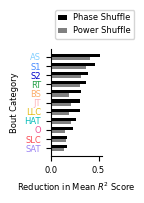

In [36]:

fig, ax = plt.subplots(figsize=(2.8*cm, 5.8*cm), facecolor='None')

# Bar plot for phase differences
bar1 = ax.barh(ind, sorted_diff_phase, width, label='Phase Shuffle', color='k')
# Bar plot for power differences
bar2 = ax.barh(ind + width, sorted_diff_power, width, label='Power Shuffle', color='gray')

# Add some text for labels, title, and custom y-axis tick labels, etc.
ax.set_ylabel('Bout Category')
ax.set_xlabel('Reduction in Mean $R^{2}$ Score')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(sorted_catname)
ax.invert_yaxis()  # Invert y axis to have the highest value at the top
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.4), ncol=1, fontsize=f_size, handleheight=0.5, handlelength=1)

# Set ytick label colors based on sorted_bout_col
for label, color in zip(ax.get_yticklabels(), sorted_bout_col):
    label.set_color(color)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

if True:  # Replace with your condition for saving figures
    fig.savefig(fig_dir/"r2_fins_shuffle_diff.pdf", bbox_inches='tight', dpi=dpi, transparent=True)
    fig.savefig(fig_dir/"r2_fins_shuffle_diff.png", bbox_inches='tight', dpi=dpi, transparent=True)
